In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from datetime import datetime

In [2]:
with pd.HDFStore('data.h5') as hdf:
    data = hdf['most_liquid_pairs_data']

In [3]:
data_returns = data[[c for c in data.columns if 'returns' in c] + ['target_1p']]

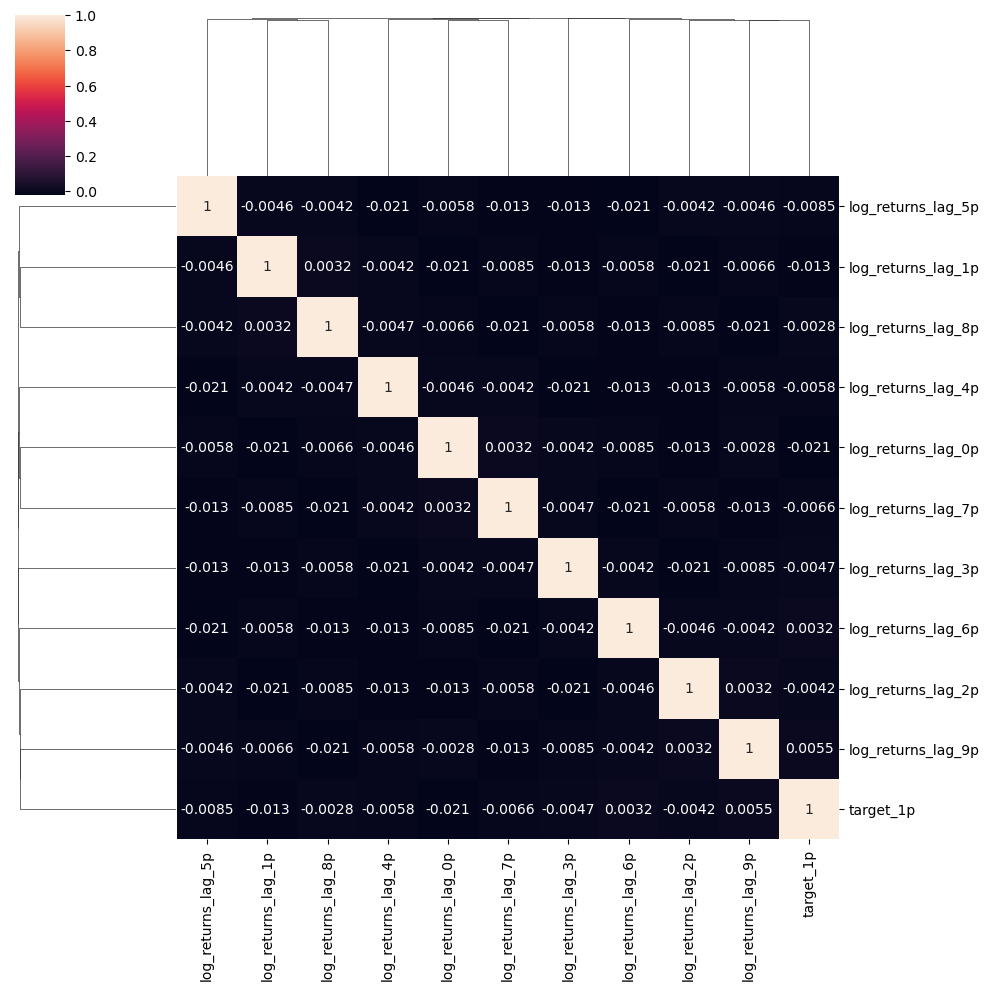

In [4]:
sns.clustermap(data_returns.corr(method='pearson'), annot=True)

In [5]:
data_returns = data_returns.join(data.rolling_std_50w)

In [6]:
high_volatility_data = data_returns.groupby(level='symbol', group_keys=False).apply(lambda x: x.sort_values(by='rolling_std_50w', ascending=False).iloc[:int(len(x)*0.1)])

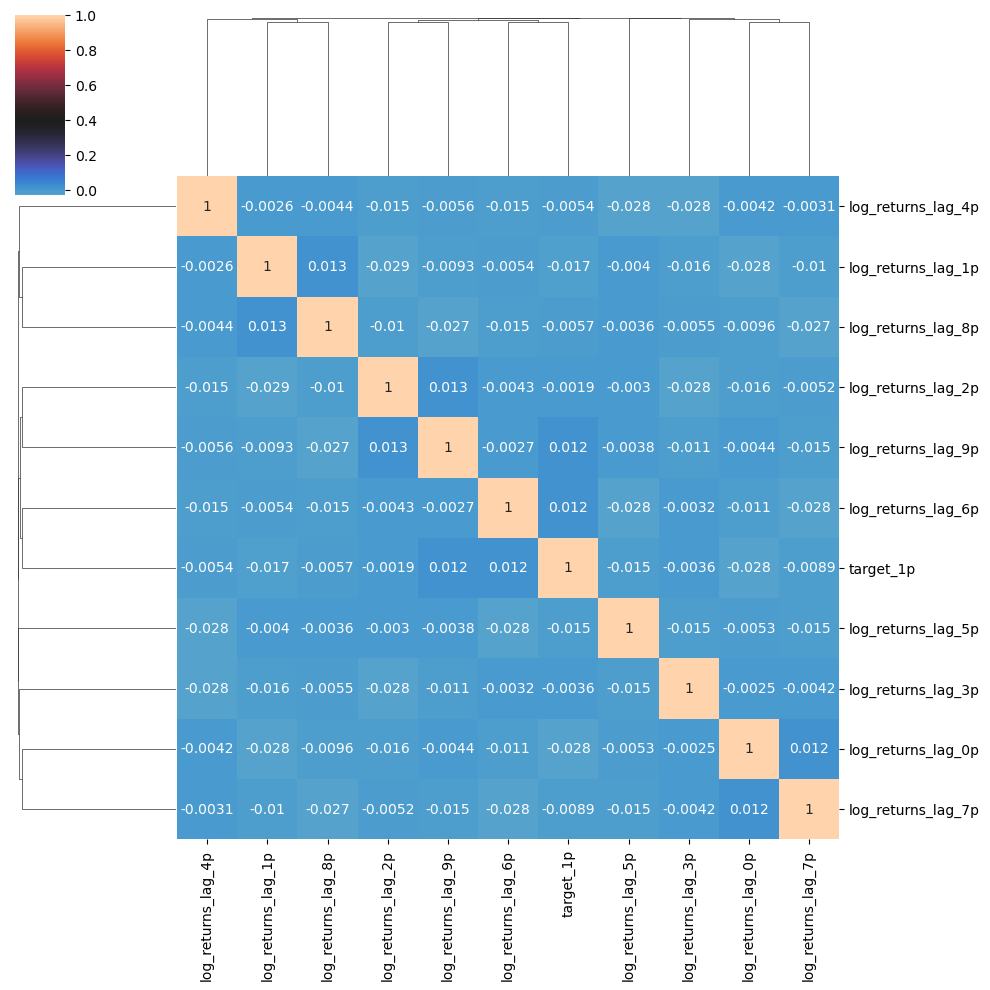

In [7]:
sns.clustermap(high_volatility_data.drop(['rolling_std_50w'], axis=1).corr(method='pearson'), annot=True, center=0.4)

In [8]:
data_rsi = data_returns.join(data.rsi)

In [9]:
data_volume = data_returns.join(data.tick_volume)

In [10]:
data_volume.groupby(level='symbol', group_keys=False).apply(lambda x: x.sort_values(by=['tick_volume', 'rolling_std_50w'], ascending=False).iloc[:int(len(x)*0.1)]).corr()

,log_returns_lag_0p,log_returns_lag_1p,log_returns_lag_2p,log_returns_lag_3p,log_returns_lag_4p,log_returns_lag_5p,log_returns_lag_6p,log_returns_lag_7p,log_returns_lag_8p,log_returns_lag_9p,target_1p,rolling_std_50w,tick_volume
log_returns_lag_0p,1.000000,-0.010331,-0.005558,0.004437,0.000229,-0.001744,-0.006194,0.017310,-0.007358,-0.002294,-0.028198,0.017106,0.001190
log_returns_lag_1p,-0.010331,1.000000,-0.008213,-0.003385,0.007116,0.001189,0.000844,-0.003663,0.019088,-0.008658,-0.015720,0.018016,-0.002476
log_returns_lag_2p,-0.005558,-0.008213,1.000000,-0.013253,-0.004536,0.006888,0.002161,-0.000694,-0.004602,0.016335,-0.003771,0.014822,0.001710
log_returns_lag_3p,0.004437,-0.003385,-0.013253,1.000000,-0.016337,-0.005309,0.004653,0.002092,-0.001167,-0.006454,-0.003194,0.014113,0.007434
log_returns_lag_4p,0.000229,0.007116,-0.004536,-0.016337,1.000000,-0.015674,-0.005814,0.003889,0.001227,-0.002505,-0.005805,0.011219,0.004595
log_returns_lag_5p,-0.001744,0.001189,0.006888,-0.005309,-0.015674,1.000000,-0.014116,-0.007455,0.004038,0.000526,-0.014544,0.009332,0.006896
log_returns_lag_6p,-0.006194,0.000844,0.002161,0.004653,-0.005814,-0.014116,1.000000,-0.015714,-0.012627,0.004915,0.015762,0.010708,0.005899
log_returns_lag_7p,0.017310,-0.003663,-0.000694,0.002092,0.003889,-0.007455,-0.015714,1.000000,-0.015129,-0.011984,-0.011631,0.008018,0.003549
log_returns_lag_8p,-0.007358,0.019088,-0.004602,-0.001167,0.001227,0.004038,-0.012627,-0.015129,1.000000,-0.014869,-0.004121,0.006397,0.002166
log_returns_lag_9p,-0.002294,-0.008658,0.016335,-0.006454,-0.002505,0.000526,0.004915,-0.011984,-0.014869,1.000000,0.009155,0.006431,-0.000635


In [2]:
import MetaTrader5 as mt

mt.initialize()

login_mt5 = 1051534030
mdp_mt5 = 'FG2SF2M74R'
server = 'FTMO-Demo'

mt.login(login_mt5, mdp_mt5, server)

True

In [5]:
def get_clean_mt5_data(tickers, interval):
    
    datas = []
    for ticker in tickers:
        
        data = pd.DataFrame(mt.copy_rates_from(ticker, interval, datetime.now(), 1000))
        data['time'] = pd.to_datetime(data['time'], unit='s')
        data['symbol'] = np.full(shape=len(data), fill_value=ticker)
        data = data.drop(['real_volume'], axis=1)
        datas.append(data)
    
    data = pd.concat(datas, axis=0)
    data = data.set_index(['symbol', 'time'])
    return data

In [7]:
symbol = ['XAUUSD', 'EURUSD', 'AAPL', 'GOOG', 'US500.cash']
data = get_clean_mt5_data(symbol, mt.TIMEFRAME_D1)

In [8]:
data['returns'] = data.groupby(level='symbol', group_keys=False).apply(lambda x: np.log(x.close/x.close.shift(1)))

In [9]:
data.dropna().groupby(level='symbol')['returns'].std()

symbol
AAPL          0.048093
EURUSD        0.004767
GOOG          0.021392
US500.cash    0.014305
XAUUSD        0.009723
Name: returns, dtype: float64

In [10]:
data.loc['US500.cash'].spread.mean()

13.747

In [11]:
data.loc['US500.cash']

,open,high,low,close,tick_volume,spread,returns
time,,,,,,,
2019-07-17,3004.34,3011.41,2979.16,2979.91,40071,0,NaN
2019-07-18,2979.11,3003.61,2973.11,3001.86,38251,0,0.007339
2019-07-19,3003.02,3008.27,2968.22,2969.02,46101,0,-0.011000
2019-07-22,2973.84,2992.74,2971.93,2988.49,26973,0,0.006536
2019-07-23,2988.35,3007.72,2986.97,3002.22,27631,0,0.004584
...,...,...,...,...,...,...,...
2023-05-22,4182.90,4208.70,4178.10,4194.20,22369,28,0.002053
2023-05-23,4194.10,4209.90,4141.30,4148.70,25316,28,-0.010908
2023-05-24,4150.60,4154.70,4103.10,4134.50,28406,28,-0.003429
